In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
from Datasets.MackeyGlass import MackeyGlass

In [3]:
Mglass1 = MackeyGlassDataset(100, 5, tau=20, seed=0)

Train_test_Split = 0.8
train_size = int(Train_test_Split * len(Mglass1))
test_size = len(Mglass1) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(Mglass1, [train_size, test_size])

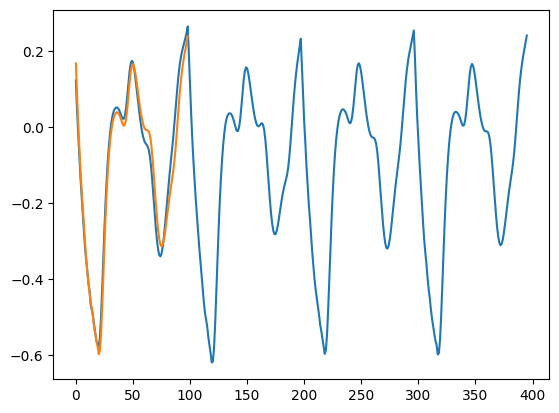

In [4]:
#BUG: This only works for feature size of atleast 2. The dataset will not concatinate otherwise.
# This one is perticularly nasty coz it just won't work even after the check.
train_data = [data[0].numpy() for data in train_dataset]
test_data = [data[0].numpy() for data in test_dataset]
try: 
    train_data = numpy.concatenate(train_data, axis=0)
    test_data = numpy.concatenate(test_data, axis=0)
except: 
    pass

plt.plot(train_data),plt.plot(test_data)
plt.show()

# ESN Performance

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available')

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

len(train_loader), len(test_loader)

GPU is available


(396, 99)

In [6]:
from Models.Echostate import ESN
device = torch.device('cuda')

esn = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1)
esn.to(device)
esn.freeze_reservoir()  # Freeze reservoir weights

# Define optimizer and criterion for the readout layer
optimizer = torch.optim.Adam(esn.readout.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [7]:
device = torch.device('cuda')
inputs = torch.tensor(train_data).to(device)
targets = torch.tensor(train_data).to(device)

for name, param in esn.named_parameters():
    print(f"{name} is on {param.device}")

print(inputs.device, targets.device)


readout.weight is on cuda:0
readout.bias is on cuda:0
cuda:0 cuda:0


In [8]:
epochs = 100
outputs = torch.rand(len(inputs), 1).to(device)  # Initialize outputs tensor
outputs.device
outputs = outputs.to(device)  # Ensure inputs are on the same device as the model
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = esn(inputs)  # Forward pass
    loss = criterion(outputs, inputs)  # Compute loss
    loss.backward()  # Backpropagate
    optimizer.step()  # Update only the readout layer
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    if epoch == epochs - 1:
        print(f"Final loss: {loss.item()}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat in method wrapper_CUDA_addmv_)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(targets.numpy(), label='True Data')
plt.plot(outputs.detach().numpy(), label='Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

In [ ]:
validation_outputs = esn(validation)
plt.figure(figsize=(10, 5))
plt.plot(validation.numpy(), label='True Data')
plt.plot(validation_outputs.detach().numpy(), label='Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')

In [ ]:
torch.version.cuda